### Introduction

In this post, I'm going to talk about visualizing high-dimensional data using the Andrews curve. This turns out to be a pretty relevant and important topic because most data that we encounter in analysis has several dimensions. "Dimensions" in this case refer to categories of attributes--like columns in a table--and it's generally the case that directly visualizing data with more than two dimensions is very low yield. We're all pretty used to a conventional scatter plot depicting data points in 2 dimensions but what if we have 3, 4, 5, 10 or more dimensions? Surely, we CAN add dimensions to our scatter plot (we could add point color, point shape, point size or a z-axis) but it quickly becomes confusing and we are likely to miss seeing associations. 

The Andrews curve exists to give a very high-level, back-of-the-envelope depiction of high-dimensional data (in fact, we could have 5, 10, or even hundreds of dimensions packed into our Andrews curve) with the purpose of illustrating whether or not the observations in that data (often the rows in a table) are similar or different and we often want to know this kind of thing because knowing whether and how data points could be grouped is a very important part of characterizing a dataset.

We'll start by demonstrating the Andrews curve module of the ever-popular pandas library using the `mtcars` dataset and then we'll dive into the math behind how these curves are calculated, eventually doing it by hand ourselves and then showing in detail how pandas pulls it off. After this, if you're interested in digging deeper into the Andrews curve there's a great article which you can read [here](https://pdfs.semanticscholar.org/8d82/dbf9d39c20af20e900ae522180f64d02b516.pdf).

I'll import `sympy` because it will help us with some of the illustrative work and I'll also import `mtcars` from the `ggplot` python package and, `andrews_curves` from `pandas.plotting`.

In [2]:
import sympy as sm
from ggplot import mtcars
import matplotlib.pyplot as plt
from pandas.plotting import andrews_curves
import numpy as np

plt.style.use('ggplot')
%matplotlib inline

And we'll pull up the top of our `mtcars` datframe to illurate that we have 12 dimensions (columns) for each observation (row) which seems sufficiently high-dimensional.

In [3]:
mtcars.head()

,name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


Now, before we demonstrate the curve, we'll do some basic data prep. First, we re-cast the `cyl` column from a continuous, integer-valued series to a categorical series of strings because we'll use this value to color-code our curves. Then, we simply ignore the `name` column from our rendering by passing only the second column and onward to the andrews_curve module with `frame = mtcars.loc[:,mtcars.columns[1:]]`.

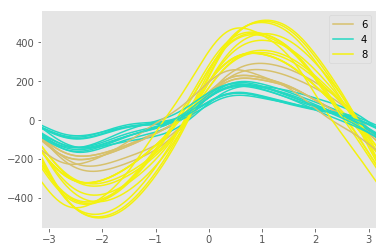

In [4]:
mtcars['cyl'] = mtcars['cyl'].apply(str)
andrews_curves(frame=mtcars.loc[:,mtcars.columns[1:]], class_column='cyl')

Pretty cool! We'll dive into exactly *how* this is calculated in a minute but first let's just appreciate what it illustrates. For all of our observations and across all of our dimensions, we can see that the data seems to strucutrally fall into two groups: the first includes the yellow traces, which has a structure that's internally consistent and pretty much unto itself, and the second includes both the green and brown traces which seem similar to one another and certainly different from the yellow traces. Of course, constructing such a high-level depiction is more of a first step in surveying and assessing data but it's given us a very important and useful insight into the data's "group-ability" right off the bat.

### Deep Dive into Andrews Curves

As you might have observed (and it's no problem if you didn't) the Andrews curve takes the data for a given observation and turns or "transforms" it into a frequency which is why it looks sort of like a sine wave. This is generally referred to as a "Fourier transform" and the math behind this transformation is based upon the very clever insights form Joseph Fourier and others that any continuous signal could be transformed into a sum of sinusoidal functions thereby converting a function in the "time-domain" into the "frequency domain."

In the particular case of the andrews curve, the transformation takes each value for an observation $\{ x_1, x_2, x_3, x_4, x_5, ... x_n \}$ (each column value for a given row in this case) and uses them as coefficients for a summed series of orthogonal basis functions like so:

$$f_x(t) = x_1/\sqrt{2} + x_2sin(t) + x_3cos(t) + x_4sin(2t) + x_5cos(2t) + \cdots$$

As you can see, each x value is a coefficient for either $sin(x)$ or $cos(x)$ alternatively and, for each cycle of $sin(x)$ and $cos(x)$, the coefficient for $t$ is increased in harmonic fashion. After $f_x(t)$ is calculated, it's plotted for all values t where $-\pi \leq t \leq \pi$. This is then done for each row and they're plotted on top of one another.

As an aside, orthogonality is an important notion here into which I'll dive deeper in other posts. It comes up often in linear algebra and vector spaces to mean "perpendicular." In the function space like this, orthogonality for two functions $f(x)$ and $g(x)$ means $\int f(x) g(x) {dx}$ equals $0$.

Now to drive that andrews formula home, we'll calculate it by hand for one row. First we'll select out a single row of the `mtcars` dataset.

In [5]:
mtcars.loc[0:0,mtcars.columns[1:]]

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,21.0,6,160.0,110,3.9,2.62,16.46,0,1,4,4


and then we'll pass that one row to `andrews_curves`. Notice that, since we're only plotting one row worth of data here, the scale of the y-axis is different than in our intitial demo figure wherein all of the rows were plotted.

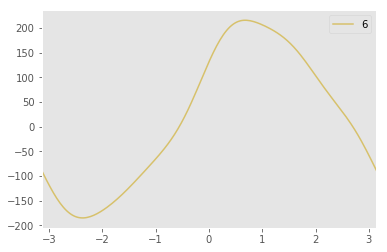

In [6]:
andrews_curves(frame=mtcars.loc[0:0,mtcars.columns[1:]], class_column='cyl')

Now as we said above, the formula for the andrews curve takes each numerical value for that row and uses it as a coefficient for a series of orthogonal functions so we'll extract all of the numerical values from that first row into a simple list.

In [7]:
mtcars_trim = mtcars.drop(['name','cyl'], axis=1)
mtcars_trim.loc[0:0,:].values.tolist()

[[21.0, 160.0, 110.0, 3.9, 2.62, 16.46, 0.0, 1.0, 4.0, 4.0]]

and we'll declare a symbol for `t` using `sympy`.

In [8]:
t = sm.symbols('t')

and finally, we'll plot our andrews curve equation using our row values as coefficients. Note that the last argument to `sm.plot` uses our symbol `t` to establish a range for valtues of `t` between $-\pi$ and $\pi$: `(t,-sm.pi, sm.pi)`.

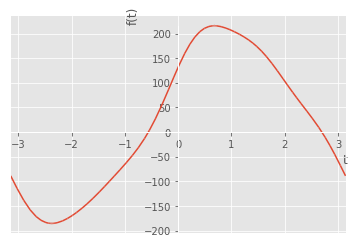

In [9]:
sm.plot(21.0*(1/2**0.5) + 160.0*sm.sin(t) + 110.0*sm.cos(t) + 3.9*sm.sin(2*t) + 2.62*sm.cos(2*t) +
        16.46*sm.sin(3*t) + 0.0*sm.cos(3*t) + 1.0*sm.sin(4*t) + 4.0*sm.cos(4*t) + 
        4.0*sm.sin(5*t), (t,-sm.pi, sm.pi))

and just like that we have a plot that's identical to what `andrews_curves` gave us! Although this might have been obvious, it's worth mentioning that the x-axis here looks like it goes from around -3 ro around 3 which is simply the numerical equivalent of going from $-\pi$ to $\pi$.

### Efficient Andrews Calculation Using Numpy

Now I calculated the andrews curve by hand because it was useful for illustrative purposes but obviously this isn't how it's done in a more production setting. For an example of a more optimized and programmatic approach, we'll take a quick peek into how pandas actually does this and, in order to do so, I've plucked out the relevant snippets from the pandas sourcecode which you can see [here](https://github.com/pandas-dev/pandas/blob/e99f56e43ab65710a34440067efe372d5f74280b/pandas/plotting/_misc.py).

First things first, we'll set up the variables that pandas is expecting. We set the numerical values of the first row of `mtcars` as the `amplitudes` vector and we use `np.linspace` to create 400 evenly spaces points ranging between $-\pi$ and $\pi$.

In [10]:
amplitudes = mtcars_trim.loc[0:0,:].values.tolist()[0]
t = np.linspace(-np.pi, np.pi, 400)

Then we run our excerpt from the pandas sourcecode. Pandas makes heavy and elegant use of the `numpy` library so there are a few interesting things to observe here. First, they chop off the first value of the `amplitides` array (remember these are the row values) and calculate the first term of the andrews curve function: $x/\sqrt{2}$. Then, they reshape the vector of row values to $2\ by\ n$ which is useful for two reasons. First, $sin(x)$ can be applied to one column while $cos(x)$ is applied to the other while still maintaining alternative order since the rows are only two items long. Second, since each row contains a complete cycle of $sin(x)$ and $cos(x)$, each row is a harmonic period. This allows for very efficient mapping both of $sin(x)$ and $cos(x)$ as well as the coefficient for $t$ for each row value.

In [11]:
x1 = amplitudes[0]
result = x1 / np.sqrt(2.0)

# Take the rest of the coefficients and resize them
# appropriately. Take a copy of amplitudes as otherwise numpy
# deletes the element from amplitudes itself.
coeffs = np.delete(np.copy(amplitudes), 0)
coeffs.resize(int((coeffs.size + 1) / 2), 2)

# Generate the harmonics and arguments for the sin and cos
# functions.
harmonics = np.arange(0, coeffs.shape[0]) + 1
trig_args = np.outer(harmonics, t)

result += np.sum(coeffs[:, 0, np.newaxis] * np.sin(trig_args) +
                 coeffs[:, 1, np.newaxis] * np.cos(trig_args),
                 axis=0)

and if we plot our values for `t` on the x-axis against our `result` vector as the y-axis, we get a plot that's identical to the one we made by hand!

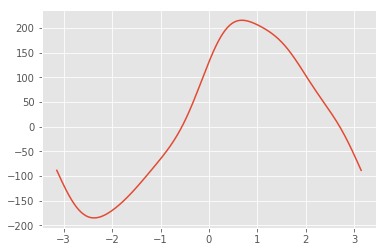

In [12]:
plt.plot(t, result)

### Andrews Curves with R

Of course andrews curves aren't exclusive to Python. They're also available in R in the `andrews` package. What's cool about the `andrews` package is that we can pass in different variations on the andrews curve formula and experiment as to which one shows us something interesting. For example, the R package supports a very interesting variant of the formula proposed by Khatree and Naik in their paper [here](http://www.sciencedirect.com/science/article/pii/S0378375801001501).

The unique thing about their approach is that each term $x_n$ is exposed to both $sin$ and $cos$ function:

$$f_x(t) = 1/\sqrt{2}  \{ x_1 + x_2(sin(t) + cos(t)) + x_3(sin(t) - cos(t)) + x_4(sin(2t) + cos(2t))... \} $$

In [13]:
%load_ext rpy2.ipython

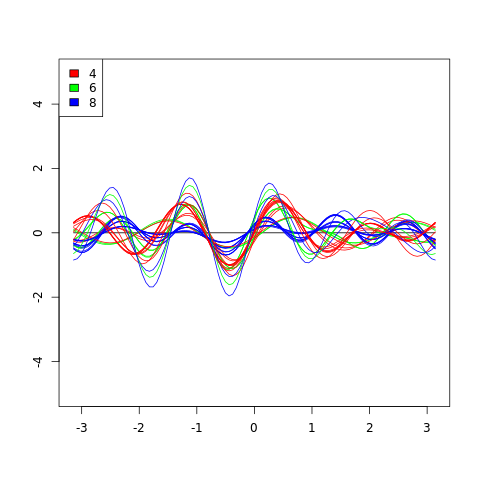

In [14]:
%%R
library(andrews)

mtcars$cyl <- as.factor(mtcars$cyl)
andrews(mtcars, type=4, ymax=5, clr=which(colnames(mtcars) == "cyl"))
legend("topleft",legend=levels(as.factor(mtcars$cyl)), fill=rainbow(length(levels(as.factor(mtcars$cyl)))))

Which shows more variability within the blue (`cyl` = 8) group. Alternatively, it also supports a variant of the form:

$$f_x(t) = x_1cos(t) + x_2cos(\sqrt{2t}) + x_3cos(\sqrt{3t}) ....$$

which actually shows perhaps the best grouping overall.

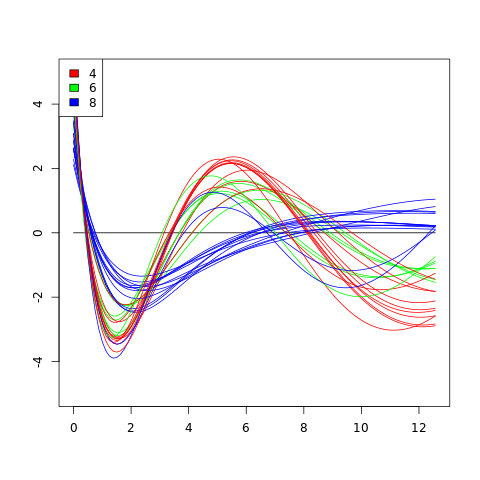

In [15]:
%%R
library(andrews)

mtcars$cyl <- as.factor(mtcars$cyl)
andrews(mtcars, type=3, ymax=5, clr=which(colnames(mtcars) == "cyl"))
legend("topleft",legend=levels(as.factor(mtcars$cyl)), fill=rainbow(length(levels(as.factor(mtcars$cyl)))))

### Conclusion

So andrews curves provide a powerful tool for getting deep structural insight into data across many dimensions and can be a great initial step in prospecting a dataset. As with all things in data science, these tools aren't black boxes and they don't do magic. Thus, with a solid understanding of what's going on under the hood, we can experiment and iterate over visualizations to get at a meaningful insight about how our data is structured.